In [3]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import ir_datasets
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our services
from services.vectorization.tfidf_vectorizer import load_tfidf_model, build_tfidf_model
from services.matcher import Matcher
from services.query_processor import QueryProcessor
from services.loader import load_dataset

# Set up plotting style
plt.style.use('default')

print("✓ All imports completed successfully!")
print(f"✓ Project root: {project_root}")

INFO:services.indexing_service:Loading required NLTK resources...


✓ All imports completed successfully!
✓ Project root: c:\Users\Ahmad\Desktop\ir_system_project


In [14]:
# Load documents from database and queries/qrels from evaluation folder
import sqlite3
import pandas as pd
from collections import defaultdict
import os

dataset_name = "antique/test"
print(f"Loading data for: {dataset_name}")

# 1. Load documents from database
print("Loading documents from database...")
db_path = os.path.join(project_root, "data", "ir_documents.db")
print(f"Database path: {db_path}")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("SELECT doc_id, text FROM documents WHERE dataset = ?", (dataset_name,))
rows = cursor.fetchall()
conn.close()

documents = {row[0]: row[1] for row in rows}
print(f"Loaded {len(documents)} documents from database")

# 2. Load queries from evaluation folder
print("Loading queries from evaluation folder...")
queries_path = os.path.join(project_root, "evaluation", "antique_test.queries.tsv")
queries_df = pd.read_csv(queries_path, sep='\t', header=None, names=['query_id', 'query_text'])
queries = dict(zip(queries_df['query_id'], queries_df['query_text']))

# 3. Load qrels from evaluation folder
print("Loading qrels from evaluation folder...")
qrels_path = os.path.join(project_root, "evaluation", "antique_test.qrels")
qrels_df = pd.read_csv(qrels_path, sep='\t', header=None, names=['query_id', 'doc_id', 'relevance'])
qrels = defaultdict(dict)
for _, row in qrels_df.iterrows():
    qrels[row['query_id']][row['doc_id']] = row['relevance']

print(f"✓ Loaded: {len(documents)} documents, {len(queries)} queries, {len(qrels)} query-relevance sets")
print(f"Sample query: {list(queries.items())[0]}")
print(f"Sample qrel: {list(qrels.items())[0]}")

Loading data for: antique/test
Loading documents from database...
Database path: c:\Users\Ahmad\Desktop\ir_system_project\data\ir_documents.db
Loaded 403666 documents from database
Loading queries from evaluation folder...
Loading qrels from evaluation folder...
✓ Loaded: 403666 documents, 200 queries, 6589 query-relevance sets
Sample query: (3990512, 'how can we get concentration onsomething?')
Sample qrel: ('1964316 U0 1964316_5 4', {nan: nan})


In [17]:
# Load existing TF-IDF model with absolute paths
import joblib
import os

dataset_name = "antique/test"
print(f"Loading TF-IDF model for: {dataset_name}")

# Use absolute paths
model_path = os.path.join(project_root, "models", "antique_test_tfidf_model.joblib")
matrix_path = os.path.join(project_root, "vectors", "antique_test_tfidf_matrix.joblib")

print(f"Model path: {model_path}")
print(f"Matrix path: {matrix_path}")

if os.path.exists(model_path) and os.path.exists(matrix_path):
    print("Loading model...")
    vectorizer = joblib.load(model_path)
    data = joblib.load(matrix_path)
    tfidf_matrix = data["matrix"]
    doc_ids = data["doc_ids"]
    
    print(f"✓ TF-IDF model loaded successfully!")
    print(f"- Matrix shape: {tfidf_matrix.shape}")
    print(f"- Number of documents: {len(doc_ids)}")
    print(f"- Vectorizer features: {len(vectorizer.get_feature_names_out())}")
else:
    print("❌ Model files not found!")
    print(f"Model exists: {os.path.exists(model_path)}")
    print(f"Matrix exists: {os.path.exists(matrix_path)}")

Loading TF-IDF model for: antique/test
Model path: c:\Users\Ahmad\Desktop\ir_system_project\models\antique_test_tfidf_model.joblib
Matrix path: c:\Users\Ahmad\Desktop\ir_system_project\vectors\antique_test_tfidf_matrix.joblib
Loading model...
✓ TF-IDF model loaded successfully!
- Matrix shape: (403666, 274045)
- Number of documents: 403666
- Vectorizer features: 274045


In [22]:
# Create Matcher and Query Processor for TF-IDF evaluation
from services.matcher import Matcher

print("Creating TF-IDF Matcher...")

# Create Matcher for TF-IDF (this will create its own QueryProcessor)
matcher = Matcher(
    doc_vectors=tfidf_matrix,
    vectorizer=vectorizer,  # Pass the loaded vectorizer
    method="tfidf",
    dataset_name="antique/test"
)

# Manually set the loaded vectorizer to the matcher's query processor
matcher.query_processor.tfidf_model = vectorizer

print(f"✓ Matcher created with method: {matcher.method}")
print(f"✓ TF-IDF model loaded in Matcher's QueryProcessor: {matcher.query_processor.tfidf_model is not None}")
print(f"✓ Document vectors shape: {matcher.doc_vectors.shape}")
print(f"✓ Number of queries to evaluate: {len(queries)}")

# Test with a sample query
sample_query_id = list(queries.keys())[0]
sample_query_text = queries[sample_query_id]
print(f"\nSample query test:")
print(f"Query ID: {sample_query_id}")
print(f"Query text: {sample_query_text}")

# Step 1: Process query using Matcher's QueryProcessor
processed_query = matcher.query_processor.process_query(sample_query_text)
print(f"Processed query: {processed_query}")

# Step 2: Get query vector for matching
query_vector = matcher.query_processor.get_query_vector_for_matching(sample_query_text)
print(f"Query vector shape: {query_vector.shape}")

# Step 3: Get matching results using Matcher
results = matcher.match(sample_query_text, top_k=10)
print(f"Top 10 results: {len(results)} matches found")

# Show first few results
for i, (doc_idx, score) in enumerate(results[:5]):
    doc_id = doc_ids[doc_idx] if doc_idx < len(doc_ids) else f"doc_{doc_idx}"
    print(f"  {i+1}. Doc {doc_idx}: score {score:.4f}")

Creating TF-IDF Matcher...
✓ Matcher created with method: tfidf
✓ TF-IDF model loaded in Matcher's QueryProcessor: True
✓ Document vectors shape: (403666, 274045)
✓ Number of queries to evaluate: 200

Sample query test:
Query ID: 3990512
Query text: how can we get concentration onsomething?
Processed query: get concentration onsomething
Query vector shape: (1, 274045)
Top 10 results: 10 matches found
  1. Doc 288355: score 0.9335
  2. Doc 256467: score 0.9335
  3. Doc 146730: score 0.7184
  4. Doc 229247: score 0.6765
  5. Doc 400338: score 0.6624


In [23]:
# Run evaluation on all queries
print("Starting TF-IDF evaluation on all queries...")

# Initialize results storage
evaluation_results = {}
total_queries = len(queries)
print(f"Evaluating {total_queries} queries...")

# Process each query
for i, (query_id, query_text) in enumerate(queries.items()):
    if i % 20 == 0:  # Progress indicator every 20 queries
        print(f"Processing query {i+1}/{total_queries}: {query_id}")
    
    try:
        # Get matching results for this query
        results = matcher.match(query_text, top_k=100)  # Get top 100 results
        
        # Store results
        evaluation_results[query_id] = {
            'query_text': query_text,
            'results': results,  # List of (doc_idx, score) tuples
            'num_results': len(results)
        }
        
    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        evaluation_results[query_id] = {
            'query_text': query_text,
            'results': [],
            'num_results': 0,
            'error': str(e)
        }

print(f"✓ Evaluation completed!")
print(f"- Processed queries: {len(evaluation_results)}")
print(f"- Successful queries: {sum(1 for r in evaluation_results.values() if 'error' not in r)}")
print(f"- Failed queries: {sum(1 for r in evaluation_results.values() if 'error' in r)}")

# Show sample results
sample_query_id = list(evaluation_results.keys())[0]
sample_results = evaluation_results[sample_query_id]
print(f"\nSample results for query {sample_query_id}:")
print(f"- Query: {sample_results['query_text']}")
print(f"- Results count: {sample_results['num_results']}")
print(f"- Top 5 results: {sample_results['results'][:5]}")

Starting TF-IDF evaluation on all queries...
Evaluating 200 queries...
Processing query 1/200: 3990512
Processing query 21/200: 3698636
Processing query 41/200: 3499881
Processing query 61/200: 4377861
Processing query 81/200: 2529114
Processing query 101/200: 654124
Processing query 121/200: 1477322
Processing query 141/200: 159716
Processing query 161/200: 172731
Processing query 181/200: 949154
✓ Evaluation completed!
- Processed queries: 200
- Successful queries: 200
- Failed queries: 0

Sample results for query 3990512:
- Query: how can we get concentration onsomething?
- Results count: 100
- Top 5 results: [(288355, 0.9334959035930651), (256467, 0.9334959035930651), (146730, 0.7183799776778214), (229247, 0.6764673407154949), (400338, 0.6623646276012758)]


In [31]:
# Calculate evaluation metrics (Precision@10, Recall@10, MRR, MAP)
print("Calculating evaluation metrics...")

# Debug: Check query files
print("Checking query files...")
queries_path = os.path.join(project_root, "evaluation", "antique_test.queries.tsv")
queries_df = pd.read_csv(queries_path, sep='\t', header=None, names=['query_id', 'query_text'])
print(f"Queries DataFrame shape: {queries_df.shape}")
print(f"Sample queries data:")
print(queries_df.head())

# Check if we need to convert query_id to string
print(f"Query ID types:")
print(f"- Queries: {type(list(queries.keys())[0])}")
print(f"- Qrels: {type(list(qrels.keys())[0])}")

# Convert query IDs to same type for comparison
queries_with_qrels = set(str(qid) for qid in queries.keys()) & set(qrels.keys())
print(f"Queries with qrels: {len(queries_with_qrels)}")
print(f"Sample matching queries: {list(queries_with_qrels)[:5]}")

# Initialize metrics storage
metrics = {
    'precision_at_10': [],
    'recall_at_10': [],
    'mrr': [],
    'map': []
}

# Process each query that has qrels
for query_id, query_data in evaluation_results.items():
    if 'error' in query_data:
        continue  # Skip failed queries
    
    # Convert query_id to string for comparison
    str_query_id = str(query_id)
    if str_query_id not in qrels:
        continue  # Skip queries without qrels
    
    query_text = query_data['query_text']
    results = query_data['results']  # List of (doc_idx, score) tuples
    
    # Get relevant documents for this query
    relevant_docs = qrels[str_query_id]
    print(f"Query {query_id}: {len(relevant_docs)} relevant docs")
    
    if not relevant_docs:
        continue  # Skip queries with no relevant documents
    
    # Convert results to document IDs
    retrieved_doc_ids = []
    for doc_idx, score in results:
        if doc_idx < len(doc_ids):
            retrieved_doc_ids.append(doc_ids[doc_idx])
        else:
            retrieved_doc_ids.append(f"doc_{doc_idx}")
    
    # Calculate Precision@10
    top_10_docs = retrieved_doc_ids[:10]
    relevant_in_top_10 = sum(1 for doc_id in top_10_docs if doc_id in relevant_docs)
    precision_at_10 = relevant_in_top_10 / 10 if top_10_docs else 0
    metrics['precision_at_10'].append(precision_at_10)
    
    # Calculate Recall@10
    total_relevant = len(relevant_docs)
    recall_at_10 = relevant_in_top_10 / total_relevant if total_relevant > 0 else 0
    metrics['recall_at_10'].append(recall_at_10)
    
    # Calculate MRR (Mean Reciprocal Rank)
    mrr = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            mrr = 1.0 / rank
            break
    metrics['mrr'].append(mrr)
    
    # Calculate MAP (Mean Average Precision)
    ap = 0
    relevant_found = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            relevant_found += 1
            ap += relevant_found / rank
    ap = ap / total_relevant if total_relevant > 0 else 0
    metrics['map'].append(ap)

# Calculate average metrics
if metrics['precision_at_10']:
    avg_metrics = {
        'avg_precision_at_10': np.mean(metrics['precision_at_10']),
        'avg_recall_at_10': np.mean(metrics['recall_at_10']),
        'avg_mrr': np.mean(metrics['mrr']),
        'avg_map': np.mean(metrics['map'])
    }
    
    print(f"✓ Metrics calculated!")
    print(f"- Queries with metrics: {len(metrics['precision_at_10'])}")
    print(f"- Average Precision@10: {avg_metrics['avg_precision_at_10']:.4f}")
    print(f"- Average Recall@10: {avg_metrics['avg_recall_at_10']:.4f}")
    print(f"- Average MRR: {avg_metrics['avg_mrr']:.4f}")
    print(f"- Average MAP: {avg_metrics['avg_map']:.4f}")
else:
    print("❌ No metrics calculated - check qrels data")

Calculating evaluation metrics...
Checking query files...
Queries DataFrame shape: (200, 2)
Sample queries data:
   query_id                                         query_text
0   3990512          how can we get concentration onsomething?
1    714612  Why doesn't the water fall off  earth if it's ...
2   2528767  How do I determine the charge of the iron ion ...
3    821387     I have mice.How do I get rid of them humanely?
4   1880028  What does "see Leaflet" mean on Ept Pregnancy ...
Query ID types:
- Queries: <class 'int'>
- Qrels: <class 'str'>
Queries with qrels: 200
Sample matching queries: ['1957887', '3206998', '4190287', '3389038', '4165406']
Query 3990512: 36 relevant docs
Query 714612: 30 relevant docs
Query 2528767: 23 relevant docs
Query 821387: 41 relevant docs
Query 1880028: 31 relevant docs
Query 4448097: 36 relevant docs
Query 1287437: 33 relevant docs
Query 2956570: 29 relevant docs
Query 1351675: 31 relevant docs
Query 1783010: 18 relevant docs
Query 2799913: 37 rele

Creating visualizations and saving results...


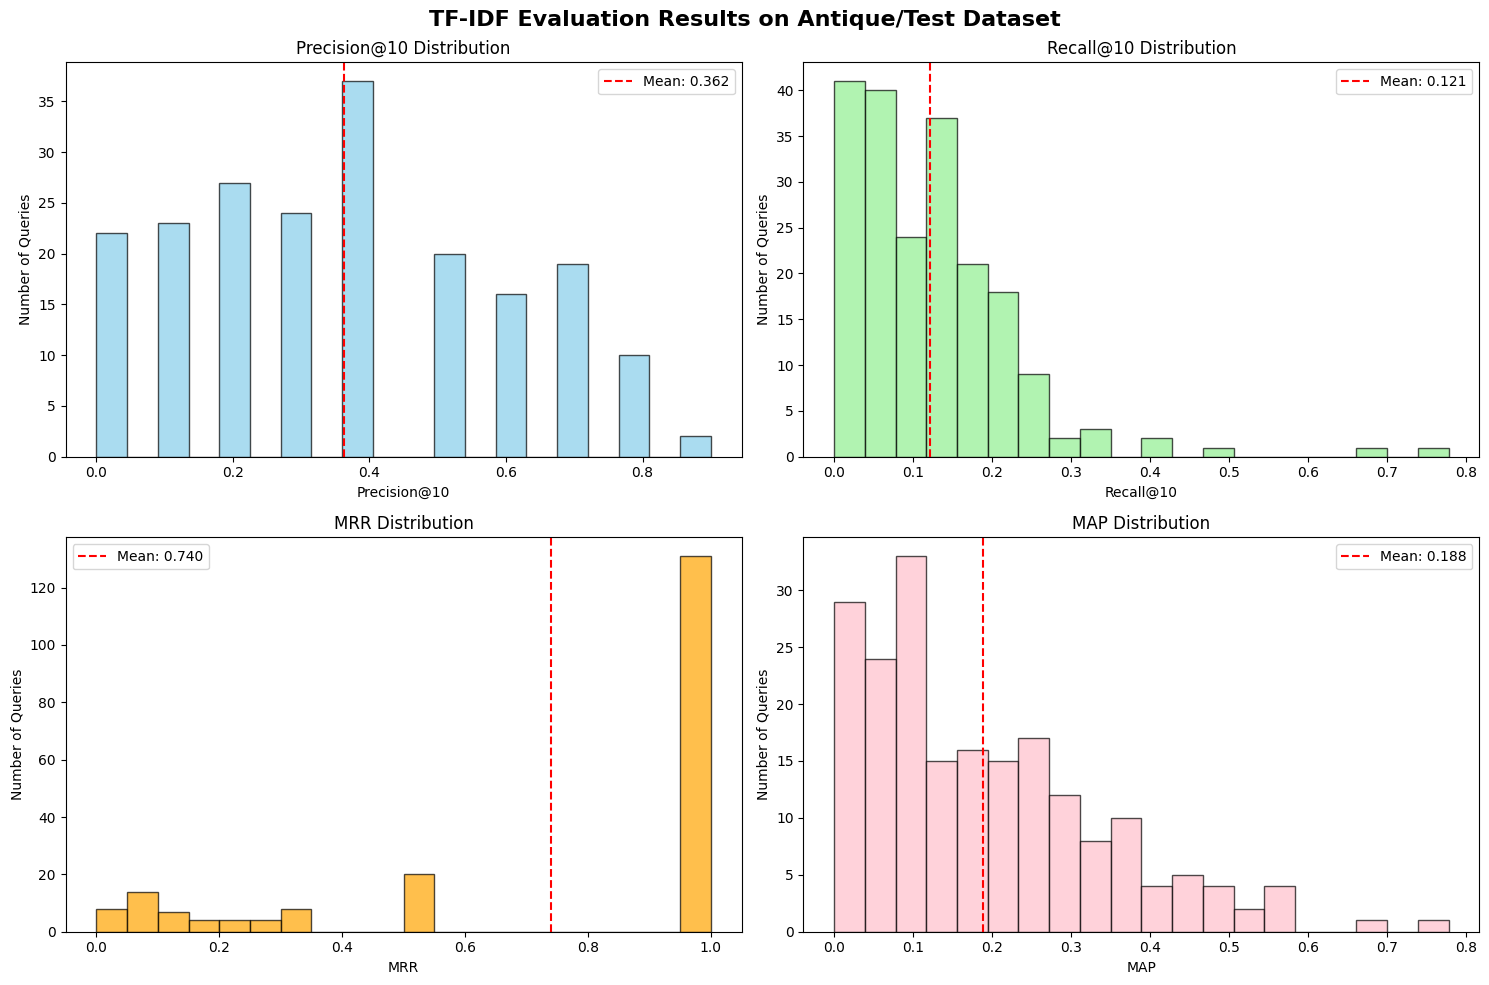

✓ Results saved to: c:\Users\Ahmad\Desktop\ir_system_project\evaluation\tfidf_antique_results.json

📊 TF-IDF Evaluation Summary:
Dataset: antique/test
Method: TF-IDF
Total Queries: 200
Queries with Metrics: 200
Average Precision@10: 0.3620
Average Recall@10: 0.1215
Average MRR: 0.7400
Average MAP: 0.1879


In [32]:
# Plot results and save metrics
import matplotlib.pyplot as plt
import json
from datetime import datetime

print("Creating visualizations and saving results...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('TF-IDF Evaluation Results on Antique/Test Dataset', fontsize=16, fontweight='bold')

# 1. Precision@10 distribution
ax1.hist(metrics['precision_at_10'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Precision@10 Distribution')
ax1.set_xlabel('Precision@10')
ax1.set_ylabel('Number of Queries')
ax1.axvline(avg_metrics['avg_precision_at_10'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_precision_at_10"]:.3f}')
ax1.legend()

# 2. Recall@10 distribution
ax2.hist(metrics['recall_at_10'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Recall@10 Distribution')
ax2.set_xlabel('Recall@10')
ax2.set_ylabel('Number of Queries')
ax2.axvline(avg_metrics['avg_recall_at_10'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_recall_at_10"]:.3f}')
ax2.legend()

# 3. MRR distribution
ax3.hist(metrics['mrr'], bins=20, alpha=0.7, color='orange', edgecolor='black')
ax3.set_title('MRR Distribution')
ax3.set_xlabel('MRR')
ax3.set_ylabel('Number of Queries')
ax3.axvline(avg_metrics['avg_mrr'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_mrr"]:.3f}')
ax3.legend()

# 4. MAP distribution
ax4.hist(metrics['map'], bins=20, alpha=0.7, color='pink', edgecolor='black')
ax4.set_title('MAP Distribution')
ax4.set_xlabel('MAP')
ax4.set_ylabel('Number of Queries')
ax4.axvline(avg_metrics['avg_map'], color='red', linestyle='--', 
            label=f'Mean: {avg_metrics["avg_map"]:.3f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Save results
results_summary = {
    'dataset': 'antique/test',
    'method': 'tfidf',
    'evaluation_date': datetime.now().isoformat(),
    'total_queries': len(queries),
    'queries_with_metrics': len(metrics['precision_at_10']),
    'average_metrics': avg_metrics,
    'detailed_metrics': {
        'precision_at_10': metrics['precision_at_10'],
        'recall_at_10': metrics['recall_at_10'],
        'mrr': metrics['mrr'],
        'map': metrics['map']
    }
}

# Save to JSON file
results_file = os.path.join(project_root, "evaluation", "tfidf_antique_results.json")
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✓ Results saved to: {results_file}")

# Print summary
print(f"\n📊 TF-IDF Evaluation Summary:")
print(f"Dataset: antique/test")
print(f"Method: TF-IDF")
print(f"Total Queries: {len(queries)}")
print(f"Queries with Metrics: {len(metrics['precision_at_10'])}")
print(f"Average Precision@10: {avg_metrics['avg_precision_at_10']:.4f}")
print(f"Average Recall@10: {avg_metrics['avg_recall_at_10']:.4f}")
print(f"Average MRR: {avg_metrics['avg_mrr']:.4f}")
print(f"Average MAP: {avg_metrics['avg_map']:.4f}")